Loading data from database...
Data loaded successfully!

--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   claim_id               15000 non-null  object        
 1   policyholder_id        15000 non-null  object        
 2   hospital_id            15000 non-null  object        
 3   claim_amount           15000 non-null  float64       
 4   diagnosis_code         15000 non-null  object        
 5   procedure_code         15000 non-null  object        
 6   claim_date             15000 non-null  datetime64[ns]
 7   is_fraud               15000 non-null  bool          
 8   age                    15000 non-null  int64         
 9   gender                 15000 non-null  object        
 10  location_policyholder  15000 non-null  object        
 11  name                   15000 non-null  o

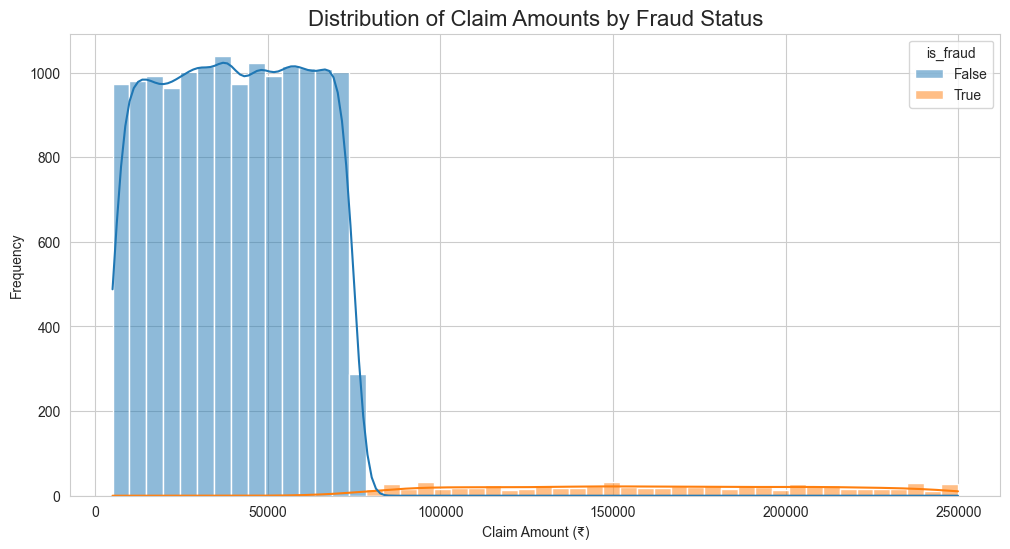

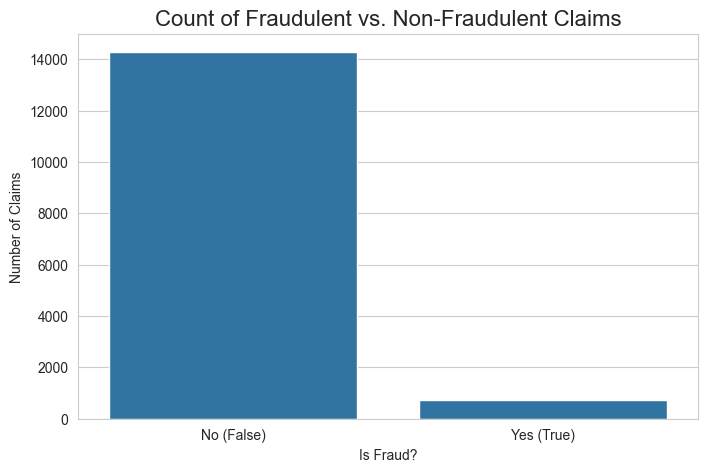

In [2]:
# notebooks/01-EDA-and-Modeling.ipynb

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('whitegrid')

# --- 2. Database Connection ---
# IMPORTANT: Replace 'your_password' with your actual PostgreSQL password.
DB_USER = 'postgres'
DB_PASSWORD = '123456789' 
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'starhealth_fraud'

# Create the database connection string and engine
DATABASE_URI = f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URI)

# --- 3. Load and Merge Data ---
print("Loading data from database...")

# Load each table into a pandas DataFrame
try:
    claims_df = pd.read_sql_table('claims', engine)
    policyholders_df = pd.read_sql_table('policyholders', engine)
    hospitals_df = pd.read_sql_table('hospitals', engine)
    print("Data loaded successfully!")
except Exception as e:
    print(f"An error occurred loading data: {e}")

# Merge the data into a single comprehensive DataFrame
# Merging claims with policyholders on 'policyholder_id'
df = pd.merge(claims_df, policyholders_df, on='policyholder_id', how='left')
# Merging the result with hospitals on 'hospital_id'
df = pd.merge(df, hospitals_df, on='hospital_id', how='left', suffixes=('_policyholder', '_hospital'))

# --- 4. Initial Exploration ---
print("\n--- Data Overview ---")
print(df.info())

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Fraud Distribution ---")
# This is a critical step: checking for class imbalance
print(df['is_fraud'].value_counts(normalize=True))


# --- 5. Key Visualizations ---
print("\nGenerating visualizations...")

# Visualization 1: How does the claim amount differ for fraudulent vs. non-fraudulent claims?
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='claim_amount', hue='is_fraud', kde=True, bins=50)
plt.title('Distribution of Claim Amounts by Fraud Status', fontsize=16)
plt.xlabel('Claim Amount (₹)')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: How many fraud vs. non-fraud claims are there?
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Count of Fraudulent vs. Non-Fraudulent Claims', fontsize=16)
plt.xlabel('Is Fraud?')
plt.ylabel('Number of Claims')
plt.xticks([0, 1], ['No (False)', 'Yes (True)'])
plt.show()


--- Starting Preprocessing and Modeling (Final Method) ---
Applying preprocessing...
Converting sparse matrix to dense NumPy array.
Applying SMOTE to the processed training data...

Training the RandomForestClassifier...
Model training complete.

--- Model Evaluation on Test Set ---
Confusion Matrix:
[[2855    0]
 [   0  145]]


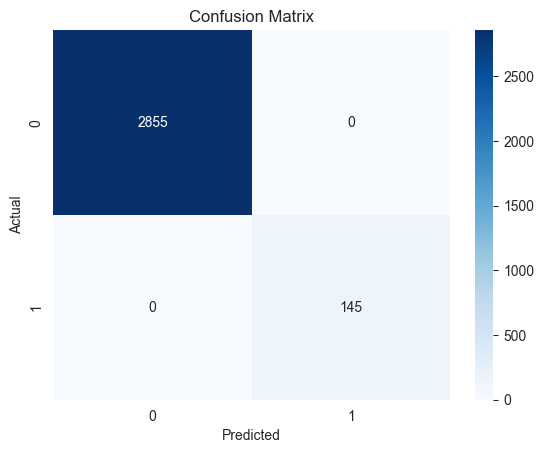


Classification Report:
                   precision    recall  f1-score   support

Not Fraud (False)       1.00      1.00      1.00      2855
     Fraud (True)       1.00      1.00      1.00       145

         accuracy                           1.00      3000
        macro avg       1.00      1.00      1.00      3000
     weighted avg       1.00      1.00      1.00      3000



In [3]:
# --- 6. Data Preprocessing for Modeling (Final Method) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import issparse # Import for checking sparse matrix

print("\n--- Starting Preprocessing and Modeling (Final Method) ---")

# Define features (X) and target (y)
# Define features (X) and target (y)
features = ['claim_amount', 'age', 'gender', 'location_policyholder', 'location_hospital', 'procedure_code']
target = 'is_fraud'

X = df[features].copy() # Use .copy() to avoid SettingWithCopyWarning
y = df[target]

# FINAL FIX: Explicitly convert each column name to a string
X.columns = [str(col) for col in X.columns]

# Define the preprocessor
numerical_features = ['claim_amount', 'age']
categorical_features = ['gender', 'location_policyholder', 'location_hospital', 'procedure_code']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 7. Apply Preprocessing and Convert to Array ---
print("Applying preprocessing...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- NEW: DEFINITIVE FIX ---
# OneHotEncoder can create a sparse matrix. We convert it to a dense NumPy array.
# This removes all column name information and guarantees the format is correct.
if issparse(X_train_processed):
    print("Converting sparse matrix to dense NumPy array.")
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

# --- 8. Apply SMOTE ---
print("Applying SMOTE to the processed training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)


# --- 9. Define and Train the Model ---
print("\nTraining the RandomForestClassifier...")
model = RandomForestClassifier(random_state=42)
# The model now receives a pure NumPy array, which will not cause the error.
model.fit(X_train_resampled, y_train_resampled)
print("Model training complete.")


# --- 10. Evaluate the Model ---
print("\n--- Model Evaluation on Test Set ---")
y_pred = model.predict(X_test_processed)

# Print Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Fraud (False)', 'Fraud (True)']))

In [7]:
import joblib
import os

print("Saving model and preprocessor...")

# Define the directory to save the files
output_dir = r'C:\Users\gogul\AI Powered Fraud Claim Detection System\backend' # We save it in the backend folder, one level up from 'notebooks'
os.makedirs(output_dir, exist_ok=True)

# Define file paths
preprocessor_path = os.path.join(output_dir, 'preprocessor.joblib')
model_path = os.path.join(output_dir, 'model.joblib')

# Save the preprocessor object
joblib.dump(preprocessor, preprocessor_path)

# Save the trained model object
joblib.dump(model, model_path)

print(f"Preprocessor saved to: {preprocessor_path}")
print(f"Model saved to: {model_path}")
print("\nModel saving complete. Phase 2 is now officially finished!")

Saving model and preprocessor...
Preprocessor saved to: C:\Users\gogul\AI Powered Fraud Claim Detection System\backend\preprocessor.joblib
Model saved to: C:\Users\gogul\AI Powered Fraud Claim Detection System\backend\model.joblib

Model saving complete. Phase 2 is now officially finished!
